In [ ]:
!pip install datasets matplotlib pillow opencv-python numpy torch torchvision


In [ ]:
from datasets import load_dataset

ds = load_dataset("Daniellau119/trad_chineseHKOCR")

train-00000-of-00002.parquet:   0%|          | 0.00/453M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/451M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'ocr'],
        num_rows: 10000
    })
})


In [ ]:
print(ds["train"][0])


{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=250x250 at 0x79BA1C8B4C90>, 'ocr': [{'box': [110.34278944051813, 59.010616276061306, 181.45973512161652, 85.02676913702264], 'cls': 0, 'word': '香港永久性居民身份證'}, {'box': [71.31606272938996, 102.92754977741737, 102.01459474477362, 120.62394445732235], 'cls': 1, 'word': '范朧石'}, {'box': [72.44498218950679, 108.69546287960722, 135.13823158010015, 132.21918313778602], 'cls': 2, 'word': 'DONG, Mls Rmpbb'}, {'box': [133.91868886382082, 142.9505397663256, 175.46602198965238, 163.6385525398766], 'cls': 3, 'word': '11-11-1974'}, {'box': [178.64839998721177, 140.7319375847106, 186.24426563384299, 154.4313534861742], 'cls': 4, 'word': '男'}, {'box': [136.74098751411296, 176.08977842917704, 167.4395195294966, 193.78617310908206], 'cls': 5, 'word': '(11-67)'}, {'box': [138.152136839259, 188.77684394277648, 182.32347340988093, 209.24649134970022], 'cls': 6, 'word': '25-07-58'}, {'box': [189.34879414916432, 177.35104270745907, 237.8314281774624

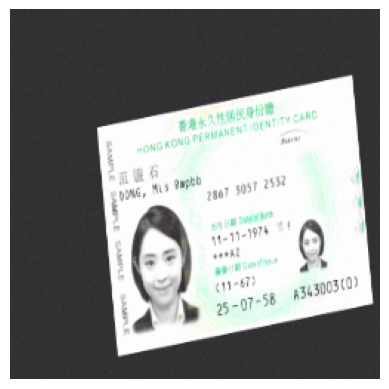

In [ ]:
import matplotlib.pyplot as plt
from datasets import load_dataset
from PIL import Image

# Load dataset
ds = load_dataset("Daniellau119/trad_chineseHKOCR")

# Extract the first image
image_data = ds["train"][0]["image"]  # Adjust key based on dataset structure

# Convert to PIL image (if it's not already in PIL format)
if isinstance(image_data, Image.Image):
    img = image_data
else:
    img = Image.fromarray(image_data)

# Display the image
plt.imshow(img)
plt.axis("off")  # Hide axes
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from datasets import load_dataset

# Load dataset from Hugging Face
dataset = load_dataset("Daniellau119/trad_chineseHKOCR")

# Extract images and labels
images = [np.array(data["image"]) for data in dataset["train"]]
labels = [data["label"] for data in dataset["train"]]

# Convert labels to categorical
num_classes = len(set(labels))
label_map = {label: idx for idx, label in enumerate(set(labels))}
labels = np.array([label_map[label] for label in labels])

# Resize images for consistency
IMG_SIZE = (64, 64)
images = np.array([cv2.resize(img, IMG_SIZE) for img in images]) / 255.0

# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Expand dimensions for CNN input
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

# Data augmentation
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1)
datagen.fit(X_train)

# Define CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    epochs=10)

# Evaluate the model
eval_results = model.evaluate(X_val, y_val)
print(f"Validation Loss: {eval_results[0]}, Validation Accuracy: {eval_results[1]}")

# Display some images with predictions
preds = model.predict(X_val[:10])
pred_labels = np.argmax(preds, axis=1)

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_val[i].squeeze(), cmap='gray')
    plt.title(f'Pred: {list(label_map.keys())[list(label_map.values()).index(pred_labels[i])]}')
    plt.axis('off')
plt.show()


KeyError: 'label'

In [ ]:

%tensorflow_version 1.x
import tensorflow as tf
import os
import random
import numpy as np
from PIL import Image
import cv2
import tensorflow.contrib.slim as slim
import logging

# Enable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Setup Logging
logger = logging.getLogger('Training a Chinese character recognition model')
logger.setLevel(logging.INFO)
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
logger.addHandler(ch)

# Define Model Parameters
tf.app.flags.DEFINE_integer('charset_size', 3509, "Number of characters to recognize.")
tf.app.flags.DEFINE_integer('image_size', 64, "Image size (64x64 pixels).")
tf.app.flags.DEFINE_boolean('gray', True, "Convert images to grayscale.")
tf.app.flags.DEFINE_integer('batch_size', 128, "Batch size for training.")
tf.app.flags.DEFINE_integer('max_steps', 16002, "Maximum training steps.")
tf.app.flags.DEFINE_string('train_data_dir', '/content/dataset/train/', "Path to training dataset.")
tf.app.flags.DEFINE_string('test_data_dir', '/content/dataset/test/', "Path to test dataset.")

FLAGS = tf.app.flags.FLAGS

# Mount Google Drive (if dataset is stored there)
from google.colab import drive
drive.mount('/content/drive')

# Define Data Loader Class
class DataIterator:
    def __init__(self, data_dir):
        self.image_names = []
        for root, _, file_list in os.walk(data_dir):
            self.image_names += [os.path.join(root, file_path) for file_path in file_list]
        random.shuffle(self.image_names)
        self.labels = [int(file_name[len(data_dir):].split(os.sep)[0]) for file_name in self.image_names]

    @property
    def size(self):
        return len(self.labels)

    def input_pipeline(self, batch_size):
        images_tensor = tf.convert_to_tensor(self.image_names, dtype=tf.string)
        labels_tensor = tf.convert_to_tensor(self.labels, dtype=tf.int64)
        input_queue = tf.train.slice_input_producer([images_tensor, labels_tensor])
        labels = input_queue[1]
        images_content = tf.read_file(input_queue[0])
        images = tf.image.decode_png(images_content, channels=1)
        images = tf.image.resize_images(images, [FLAGS.image_size, FLAGS.image_size])
        image_batch, label_batch = tf.train.shuffle_batch([images, labels], batch_size=batch_size, capacity=50000, min_after_dequeue=10000)
        return image_batch, label_batch

# Build Model
def build_model():
    images = tf.placeholder(tf.float32, shape=[None, FLAGS.image_size, FLAGS.image_size, 1], name='images')
    labels = tf.placeholder(tf.int64, shape=[None], name='labels')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')

    with slim.arg_scope([slim.conv2d, slim.fully_connected], normalizer_fn=slim.batch_norm):
        net = slim.conv2d(images, 64, [3, 3], scope='conv1')
        net = slim.max_pool2d(net, [2, 2], scope='pool1')
        net = slim.conv2d(net, 128, [3, 3], scope='conv2')
        net = slim.max_pool2d(net, [2, 2], scope='pool2')
        net = slim.conv2d(net, 256, [3, 3], scope='conv3')
        net = slim.flatten(net)
        net = slim.fully_connected(net, 1024, activation_fn=tf.nn.relu, scope='fc1')
        logits = slim.fully_connected(net, FLAGS.charset_size, activation_fn=None, scope='fc2')

    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(loss)

    return images, labels, keep_prob, train_op, loss

# Train Model
def train():
    train_data = DataIterator(FLAGS.train_data_dir)
    test_data = DataIterator(FLAGS.test_data_dir)

    images, labels, keep_prob, train_op, loss = build_model()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(FLAGS.max_steps):
            batch_images, batch_labels = train_data.input_pipeline(FLAGS.batch_size)
            _, loss_value = sess.run([train_op, loss], feed_dict={images: batch_images, labels: batch_labels, keep_prob: 0.5})
            if step % 100 == 0:
                print(f'Step {step}, Loss: {loss_value}')

# Run Training
train()
